*Ivan Scherbakoff | OTUS ML BASIC*

# Classification: Is a Near-Earth Object hazardous?

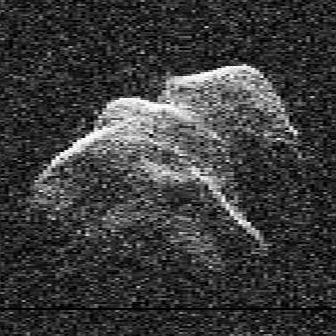

Asteroid (4179) Tautatis is a potentially dangerous object passing at a distance of 2.3 times the distance to the Moon. *(available in our dataset))*

**Near—Earth object*(N.E.O.)*** is an object of the Solar System whose orbit passes in close proximity to the Earth. The perihelion of all near-Earth objects is less than 1.3 au.

[*Wikipedia*](https://en.wikipedia.org/wiki/4179_Toutatis)

**Task:**

According to the available data, to understand: does a near-Earth Object ** pose a danger?

# Imports

In [ ]:
!pip install category_encoders
!pip install catboost
!pip install lightgbm
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.1 MB/s eta 0:00:00


In [ ]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import RandomizedSearchCV
from category_encoders import OrdinalEncoder, OneHotEncoder, CountEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score
from imblearn.over_sampling import SMOTE

from google.colab import files
from tqdm.notebook import tqdm
import os
import zipfile
import json
import pickle

In [ ]:
def search_for_the_best_model(X_train, X_train_scaled, y_train, X_test, X_test_scaled, y_test):
    pbar = tqdm(total=13)

    DT = DecisionTreeClassifier()
    RForest = RandomForestClassifier()
    CBoost = CatBoostClassifier(logging_level='Silent')
    KNN = KNeighborsClassifier()
    LogR = LogisticRegression()
    LGBM = LGBMClassifier()

    DT_RS = RandomizedSearchCV(DT, {"criterion": ["gini", "entropy", "log_loss"],
                                    "max_depth": [int(x) for x in np.linspace(10, 110, num=11)] + [None]},
                                    scoring="recall",
                                    random_state=1)

    pbar.update(1)

    RForest_RS = RandomizedSearchCV(RForest, {"criterion": ["gini", "entropy", "log_loss"],
                                    "max_depth": [int(x) for x in np.linspace(10, 80, num=8)] + [None],
                                    "n_estimators": [int(x) for x in np.linspace(start=10, stop=300, num=10)],},
                                    scoring="recall",
                                    random_state=1)

    pbar.update(1)

    CBoost_RS = RandomizedSearchCV(CBoost, {"iterations" : [int(x) for x in np.linspace(start=10, stop=300, num=10)]},
                                   scoring="recall",
                                   random_state=1)

    pbar.update(1)

    KNN_RS = RandomizedSearchCV(KNN, {"n_neighbors": [int(x) for x in np.linspace(start=2, stop=30, num=10)]},
                                    scoring="recall",
                                    random_state=1)

    pbar.update(1)

    LogR_RS = RandomizedSearchCV(LogR, {"penalty": ["l2", None]},
                                        scoring="recall",
                                        random_state=1)

    pbar.update(1)

    LGBM_RS = RandomizedSearchCV(LGBM, {"boosting_type": ["gbdt", "dart", "rf"],
                                    "max_depth": [int(x) for x in np.linspace(10, 110, num=11)] + [-1],
                                    "n_estimators": [int(x) for x in np.linspace(start=10, stop=300, num=10)]},
                                    scoring="recall",
                                    random_state=1)

    pbar.update(1)

    DT_RS.fit(X_train, y_train)

    pbar.update(1)

    RForest_RS.fit(X_train, y_train)

    pbar.update(1)

    CBoost_RS.fit(X_train, y_train)

    pbar.update(1)

    KNN_RS.fit(X_train_scaled, y_train)

    pbar.update(1)

    LogR_RS.fit(X_train_scaled, y_train)

    pbar.update(1)

    LGBM_RS.fit(X_train, y_train)

    pbar.update(1)

    results = pd.concat(
    [model_score(DT_RS.predict(X_test), "DecisionTree"),
     model_score(RForest_RS.predict(X_test), "RandomForest"),
     model_score(CBoost_RS.predict(X_test), "CatBoost"),
     model_score(KNN_RS.predict(X_test_scaled), "KNeighbors"),
     model_score(LogR_RS.predict(X_test_scaled), "Logistic"),
     model_score(LGBM_RS.predict(X_test), "LGBM"),
     ],
    axis=1)

    pbar.update(1)

    pbar.close()

    return results

def min_max_norm(x):
    return (x - x.min()) / (x.max() - x.min())

def model_score(y_pred, name="Baseline"):
    return pd.DataFrame({name:[ accuracy_score(y_pred, y_test),
                        precision_score(y_test, y_pred),
                        f1_score(y_test, y_pred),
                        recall_score(y_test, y_pred)]},
                        index=["Accuracy", "Precision", "F1", "Recall"])

In [ ]:
plt.style.use('dark_background')

# If you download from a PC:

In [ ]:
my_df = files.upload()

# If you download from Kaggle:

In [ ]:
kaggle_json = files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d ivansher/nasa-nearest-earth-objects-1910-2024

In [ ]:
with zipfile.ZipFile('nasa-nearest-earth-objects-1910-2024.zip', 'r') as zip_ref:
    zip_ref.extractall('nearest-earth-objects')

# Working on the Dataset

In [ ]:
df_original = pd.read_csv('nearest-earth-objects/nearest-earth-objects(1910-2024).csv')

In [ ]:
df = df_original.copy()

**N.E.O.- Near-Earth Objects**

**Features:**
*   `neo_id` - unique id **N.E.O.**
*   `name` - name **N.E.O.**
*   `absolute_magnitude` - shows the brightness of **N.E.O.**, and if absolute_magnitude is less, then the brightness is greater
*   `estimated_diameter_min`/`estimated_diameter_max` - minimum/maximum design diameter*(in km)*
*   `orbiting_body`	- the body rotates around **N.E.O.**
*   `relative_velocity` - relative speed*(in km/h)*
*   `miss_distance` - distance to orbiting_body*(in km)*

**Target feature*(What we predict)***:
*   `is_hazardous` - is **N.E.O.** *dangerous (according to **NASA** calculations)*

In [ ]:
df.head()

,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous
0,2162117,162117 (1998 SD15),19.14,0.394962,0.883161,Earth,71745.401048,5.814362e+07,False
1,2349507,349507 (2008 QY),18.50,0.530341,1.185878,Earth,109949.757148,5.580105e+07,True
2,2455415,455415 (2003 GA),21.45,0.136319,0.304818,Earth,24865.506798,6.720689e+07,False
3,3132126,(2002 PB),20.63,0.198863,0.444672,Earth,78890.076805,3.039644e+07,False
4,3557844,(2011 DW),22.70,0.076658,0.171412,Earth,56036.519484,6.311863e+07,False


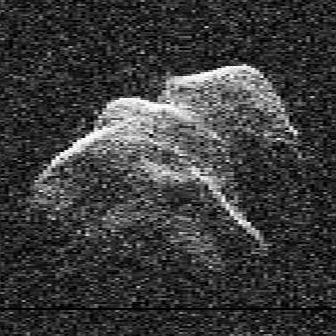

`df.iloc[297074]`

In [ ]:
df.iloc[297074]

neo_id                                    2004179
name                      4179 Toutatis (1989 AC)
absolute_magnitude                          15.31
estimated_diameter_min                   2.304385
estimated_diameter_max                   5.152761
orbiting_body                               Earth
relative_velocity                    66007.428045
miss_distance                     37578443.100515
is_hazardous                                 True
Name: 297074, dtype: object

The situation as of 07/22/2024:

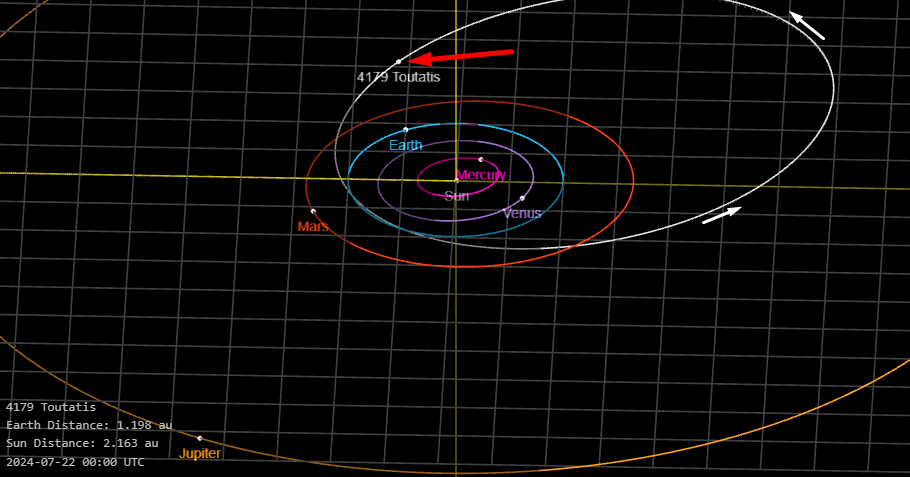

Since the list is **N.E.O.** *(Near-Earth Objects)* it does not change every 7 days (N.E.O. will not fly so far in 7 days), we have records with the same `neo_id` and `name`, but since N.E.O. still move, we do not have complete duplicates:

In [ ]:
f"Duplicate records: {df.shape[0] - df.drop_duplicates().shape[0]}"

In [ ]:
print(f"Total entries: {df.shape[0]} \n")
df.nunique()

By `estimated_diameter_min` and `estimated_diameter_max` - apparently many N.E.O.'s have ~ equal size.

In [ ]:
df.drop(["neo_id",
         "name",
         "orbiting_body",],
        axis=1,
        inplace=True)

In [ ]:
df.isnull().sum()

absolute_magnitude        28
estimated_diameter_min    28
estimated_diameter_max    28
relative_velocity          0
miss_distance              0
is_hazardous               0
dtype: int64

There are a few omissions - let's fill in mean() by column.

In [ ]:
df.absolute_magnitude.fillna(df.absolute_magnitude.mean(), inplace=True)
df["estimated_diameter_min"].fillna(df["estimated_diameter_min"].mean(), inplace=True)
df["estimated_diameter_max"].fillna(df["estimated_diameter_max"].mean(), inplace=True)

Advantages of `dataset':
+ All signs (except target) are numeric

Cons:
+ Target is unevenly distributed

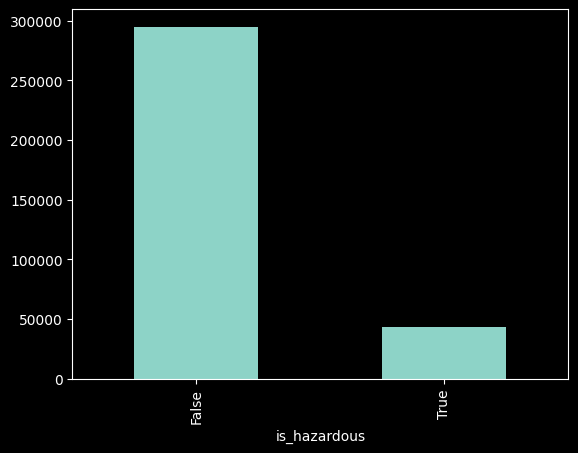

In [ ]:
df.is_hazardous.value_counts().plot(kind="bar");

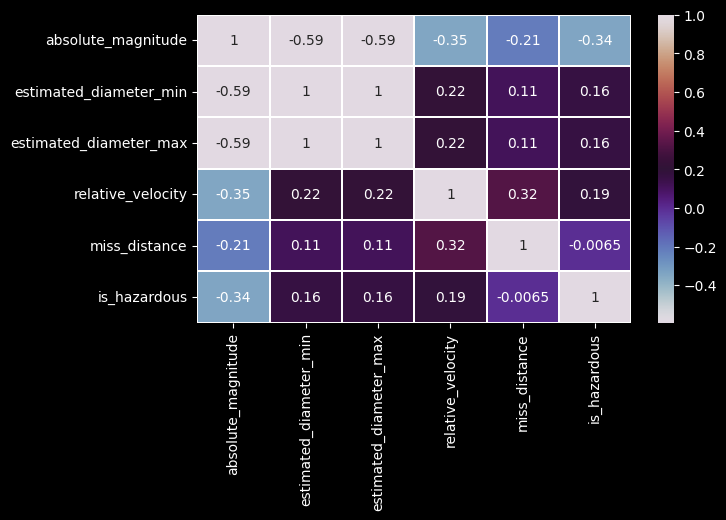

In [ ]:
plt.figure(figsize=(7, 4))
sns.heatmap(df.corr(), cmap="twilight", annot=True, cbar=True, linewidths=0.2)
plt.show()

`absolute_magnitude` correlates with the size, since `absolute_magnitude` shows the brightness of **N.E.O.**, and if `absolute_magnitude` is smaller, then the brightness is greater. Therefore, the higher the brightness, the larger the size, hence the negative correlation: `absolute_magnitude` is smaller(brighter) -> the size is larger.

`estimated_diameter_min` and `estimated_diameter_max' are strongly correlated, leaving only `estimated_diameter_max' (Max)

In [ ]:
df.drop(["estimated_diameter_min",],
        axis=1,
        inplace=True)

The correlation map shows that `is_hazardous` correlates best with `absolute_magnitude` and `relative_velocity'.

We know that if `absolute_magnitude` is smaller, then the size is larger -> more dangerous. It follows from this that we can introduce a formula for the ratio of these 2 features. At the same time, we normalize the signs so that one is not more valuable.

Formula:

$ VMr = \frac{norm(relative.velocity)}{norm(absolute.magnitude)} $

*(VMr - nVelocity nMagnitude ratio)*

It turns out a feature that:

* Grows when `relative_velocity` grows and `absolute_magnitude` falls (NEO is fast and big - our sign is big)
* Falls when `relative_velocity` falls and `absolute_magnitude` grows (NEO is slow and small - our sign is small)

Let's add such a new feature:

In [ ]:
df['velocity_magnitude_ratio'] = min_max_norm(df['relative_velocity']) / (min_max_norm(df['absolute_magnitude'])) + (min_max_norm(df['estimated_diameter_max']))
df.replace([np.inf, -np.inf], 1, inplace=True)

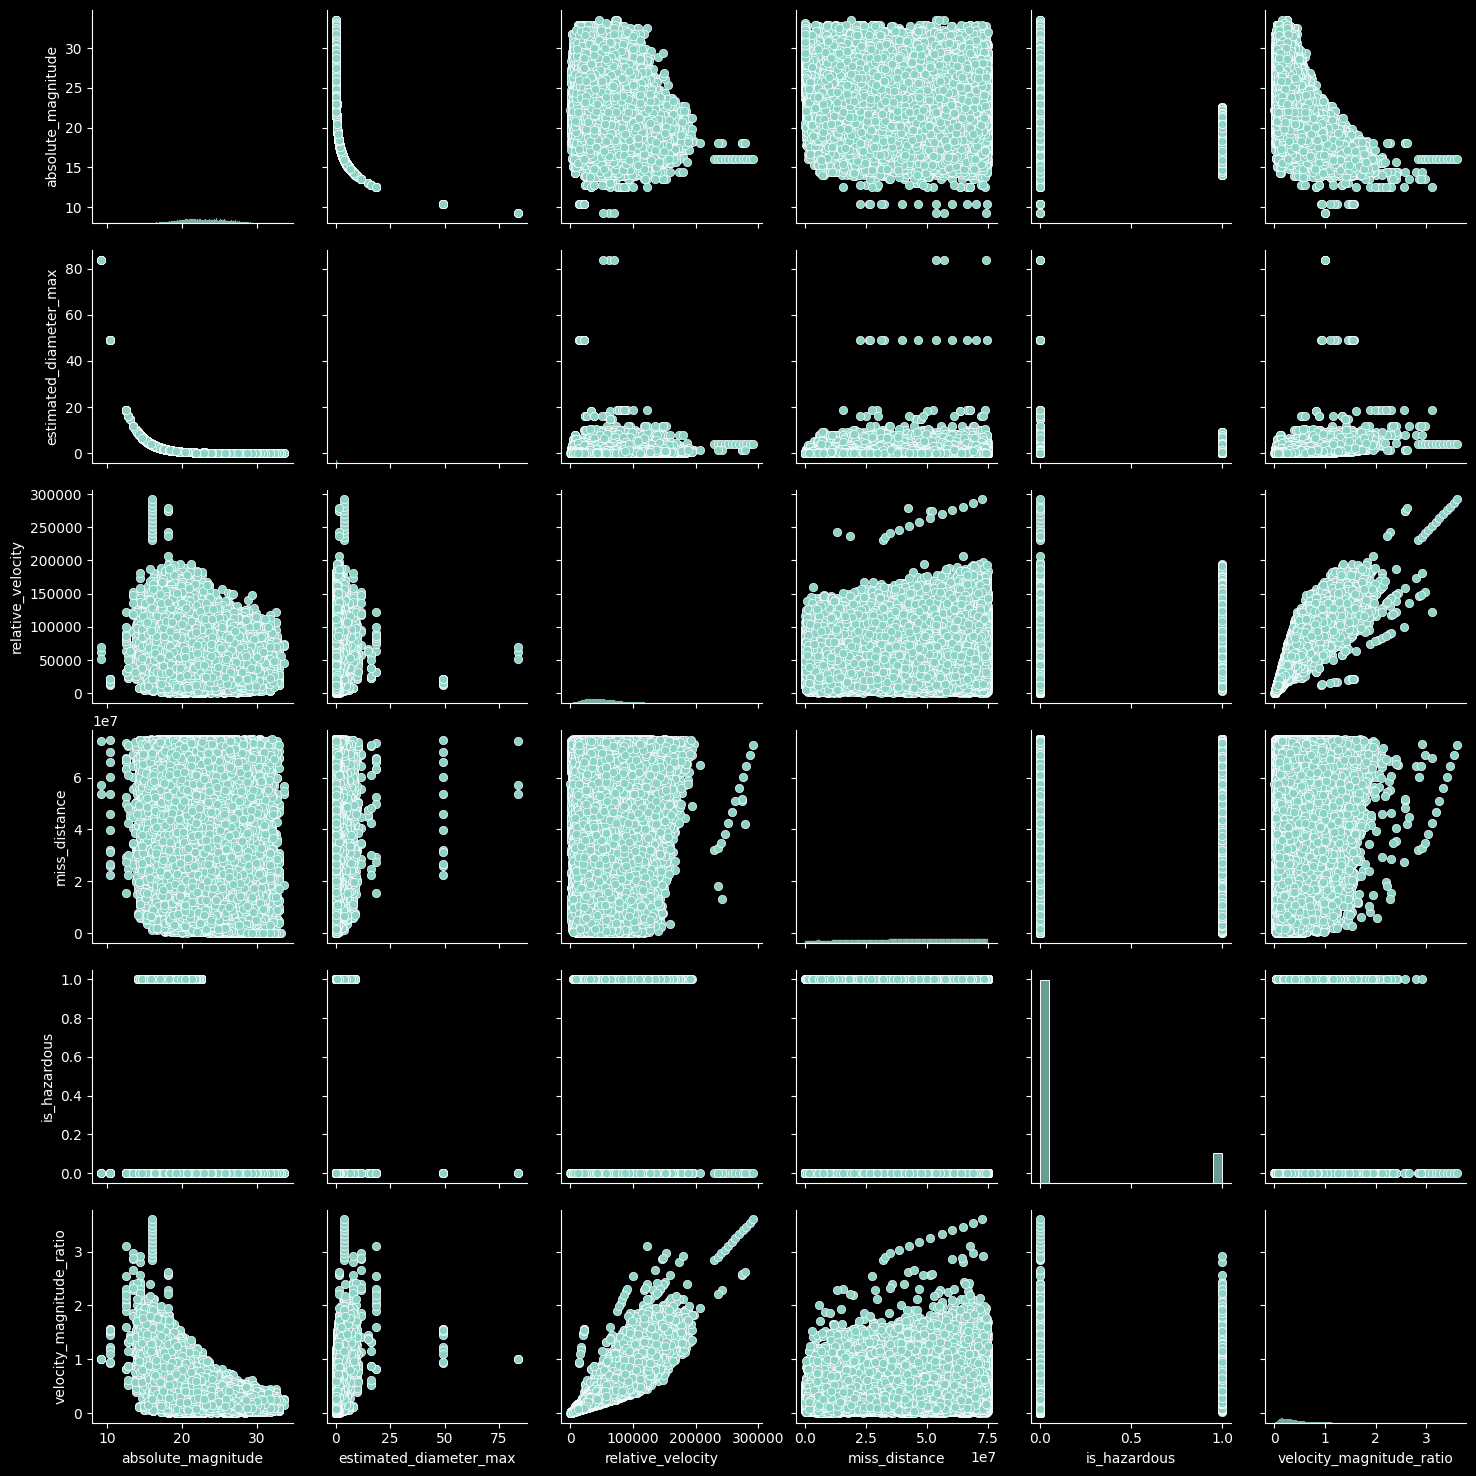

In [ ]:
sns.pairplot(df)
plt.show()

In [ ]:
df.head()

,absolute_magnitude,estimated_diameter_max,relative_velocity,miss_distance,is_hazardous,velocity_magnitude_ratio
0,19.14,0.883161,71745.401048,5.814362e+07,False,0.614111
1,18.50,1.185878,109949.757148,5.580105e+07,True,1.004114
2,21.45,0.304818,24865.506798,6.720689e+07,False,0.172295
3,20.63,0.444672,78890.076805,3.039644e+07,False,0.582245
4,22.70,0.171412,56036.519484,6.311863e+07,False,0.348412


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['is_hazardous'], axis=1),
    df['is_hazardous'],
    test_size=0.2,
    random_state=1)

scaler = StandardScaler() # Scaler

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
smote = SMOTE(random_state=1) # SMOTE (over-sampling)
X_train_scaled_smote, y_train_scaled_smote = smote.fit_resample(X_train_scaled, y_train)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In order to get rid of this `target` distribution, I use the `oversampling` method (increasing records of a smaller class) - `SMOTE'.

*Visual animation of how `SMOTE` works:*

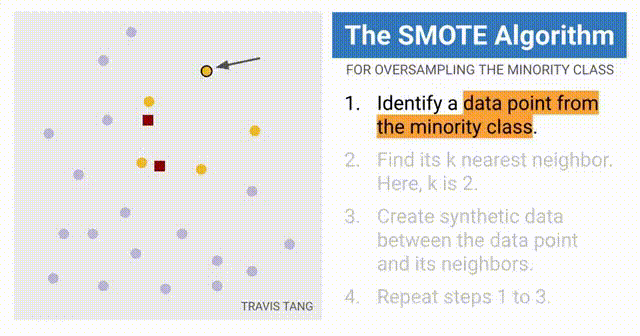

[*youtube*](https://www.youtube.com/watch?v=NvrfSntsm7w&list=LL&index=1&ab_channel=TravisTang)

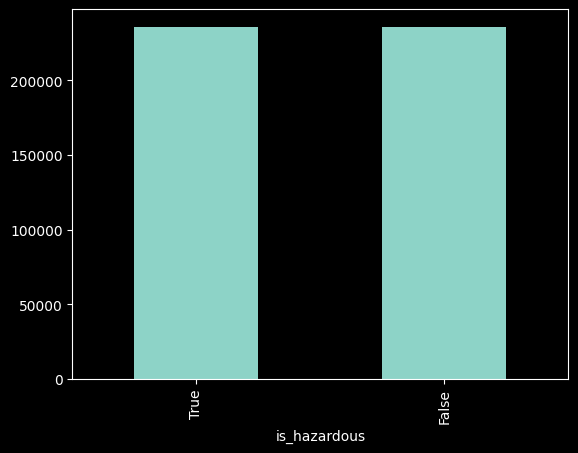

In [ ]:
y_train_scaled_smote.value_counts().plot(kind="bar");

# Baseline

In [ ]:
model = RandomForestClassifier(random_state=1)
model.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=1)

Let's look at the importance of the signs.

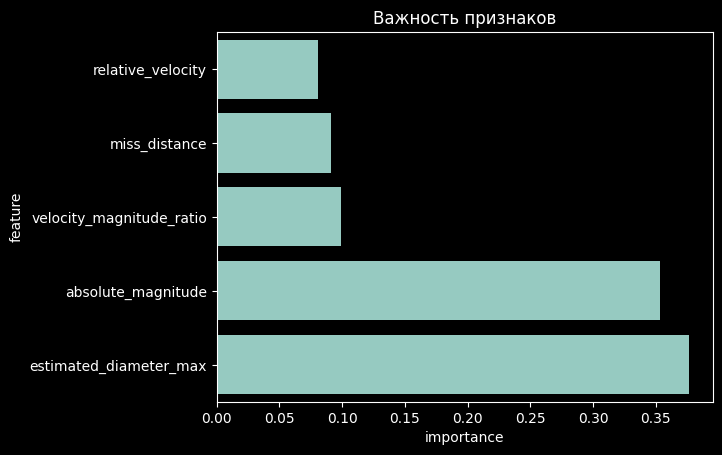

In [ ]:
feature_importances = zip(df.drop(['is_hazardous'], axis=1).columns, model.feature_importances_)
feature_importances = sorted(feature_importances, key=lambda x: x[1])
feature_importances = pd.DataFrame(feature_importances, columns=['feature', 'importance'])

sns.barplot(x='importance', y='feature', data=feature_importances)
plt.show()

In [ ]:
model_score(model.predict(X_test))

,Baseline
Accuracy,0.902158
Precision,0.594705
F1,0.653653
Recall,0.725572


On average, we will focus on **Recall**, since the cost of error is too high (after all, we are talking about the danger of asteroids). Let's say a couple of times not dangerous **N.E.O.** - dangerous than the other way around. But we will also look at other metrics.

$ RECALL = \frac{TP}{TP+FN} $

*(share of all correctly **predicted** dangerous **N.E.O.** of **all** dangerous)*

# We are looking for the best solution...

First, we will find the best model:
* let's slightly adjust the parameters of each
* compare metrics
* let's choose the best one

In [ ]:
search_for_the_best_model(X_train_smote, X_train_scaled_smote, y_train_smote, X_test, X_test_scaled, y_test)

  0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 188803, number of negative: 188803
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 188803, number of negative: 188803
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 188803, number of negative: 188803
[

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py", line 1142, in fit
    super().fit(
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py", line 842, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py", line 255, in train
    boost

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 236004, number of negative: 236004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 472008, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,DecisionTree,RandomForest,CatBoost,KNeighbors,Logistic,LGBM
Accuracy,0.888513,0.815376,0.747221,0.826478,0.734373,0.751449
Precision,0.554611,0.399824,0.327971,0.404058,0.309135,0.333130
F1,0.589427,0.553649,0.486331,0.528994,0.457633,0.493492
Recall,0.628907,0.899849,0.940397,0.765772,0.880679,0.951551


We see that by Recall the best ones are `CatBoost` and `LGBM'. But at the same time, according to all other metrics, `Random Forest` wins.

If you calculate the average for all metrics, the best will be `CatBoost` and `Random Forest'.
But still, choose `Cut Boost`, `Random Forest` and `LGBM'. We need 3 models to apply `VotingClassifier()` later. We have selected the best models and are starting deep tuning.

# RandomForest

In [ ]:
RForest = RandomForestClassifier()

In [ ]:
RForest_RS = RandomizedSearchCV(RForest, {"criterion": ["gini", "entropy", "log_loss"],
                                    "max_depth": [int(x) for x in np.linspace(10, 110, num=11)] + [None],
                                    "n_estimators": [int(x) for x in np.linspace(start=10, stop=310, num=20)] + [100],
                                    "min_samples_split": [int(x) for x in np.linspace(start=2, stop=5, num=4)],
                                    "max_features": ["sqrt", "log2", None] + [int(x) for x in np.linspace(start=2, stop=5, num=4)],
                                    "max_leaf_nodes": [None] + [int(x) for x in np.linspace(start=10, stop=60, num=8)]},
                                    scoring="recall",
                                    random_state=1)

In [ ]:
RForest_RS.fit(X_train_smote, y_train_smote)

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['sqrt', 'log2', None,
                                                         2, 3, 4, 5],
                                        'max_leaf_nodes': [None, 10, 17, 24, 31,
                                                           38, 45, 52, 60],
                                        'min_samples_split': [2, 3, 4, 5],
                                        'n_estimators': [10, 25, 41, 57, 73, 88,
                                                         104, 120, 136, 152,
                                                         167, 183, 199, 215,
                                                         231, 246, 262, 278,
                                                         294, 310, 100]},
                   random_state=1, scoring='recall')

In [ ]:
scoreRF = model_score(RForest_RS.predict(X_test))

scoreRF.to_csv('score(RF).csv', index=False)
files.download('score(RF).csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
scoreRF.head()

,Baseline
Accuracy,0.734373
Precision,0.320841
F1,0.482651
Recall,0.973742


In [ ]:
best_params_RF = RForest_RS.best_params_

with open('best_params(RF).txt', 'w') as f:
    json.dump(best_params_RF, f)
files.download('best_params(RF).txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# CatBoost

In [ ]:
CBoost = CatBoostClassifier(logging_level='Silent')

In [ ]:
CBoost_RS = RandomizedSearchCV(CBoost, {"iterations" : [int(x) for x in np.linspace(start=10, stop=300, num=10)],
                                        "learning_rate" : np.append(np.linspace(start=0.01, stop=0.5, num=10), 0.03),
                                        "depth" : [int(x) for x in np.linspace(start=2, stop=10, num=5)] + [6],
                                        "l2_leaf_reg" : np.append(np.linspace(start=0.01, stop=0.5, num=10), 3.0),
                                        "boosting_type" : ["Plain", "Ordered"],
                                        "loss_function" : ["Logloss", "CrossEntropy"]},
                                   scoring="recall",
                                   random_state=1)

In [ ]:
CBoost_RS.fit(X_train_smote, y_train_smote)

RandomizedSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x7a8af028e350>,
                   param_distributions={'boosting_type': ['Plain', 'Ordered'],
                                        'depth': [2, 4, 6, 8, 10, 6],
                                        'iterations': [10, 42, 74, 106, 138,
                                                       171, 203, 235, 267,
                                                       300],
                                        'l2_leaf_reg': array([0.01      , 0.06444444, 0.11888889, 0.17333333, 0.22777778,
       0.28222222, 0.33666667, 0.39111111, 0.44555556, 0.5       ,
       3.        ]),
                                        'learning_rate': array([0.01      , 0.06444444, 0.11888889, 0.17333333, 0.22777778,
       0.28222222, 0.33666667, 0.39111111, 0.44555556, 0.5       ,
       0.03      ]),
                                        'loss_function': ['Logloss',
                                                          'CrossEntropy']},
                   random_state=1, scoring='recall')

In [ ]:
scoreCB = model_score(CBoost_RS.predict(X_test))

scoreCB.to_csv('score(CB).csv', index=False)
files.download('score(CB).csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
scoreCB.head()

,Baseline
Accuracy,0.734536
Precision,0.320742
F1,0.482297
Recall,0.971767


In [ ]:
best_params_CB = CBoost_RS.best_params_

with open('best_params(CB).txt', 'w') as f:
    json.dump(best_params_CB, f)
files.download('best_params(CB).txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# LGBM

In [ ]:
LGBM = LGBMClassifier(verbosity=-1)

In [ ]:
LGBM_RS = RandomizedSearchCV(LGBM, {"boosting_type": ["gbdt", "dart", "rf"],
                                    "max_depth": [int(x) for x in np.linspace(10, 110, num=13)] + [-1],
                                    "n_estimators": [int(x) for x in np.linspace(start=10, stop=300, num=13)] + [100],
                                    "learning_rate" : np.append(np.linspace(start=0.01, stop=0.5, num=13), 0.1),
                                    "num_leaves" : [int(x) for x in np.linspace(10, 65, num=13)] + [31],
                                    "bagging_freq": [1],
                                    "bagging_fraction": [0.8],
                                    "feature_fraction": [0.8]},
                                    scoring="recall",
                                    random_state=1)

In [ ]:
LGBM_RS.fit(X_train_smote, y_train_smote)

RandomizedSearchCV(estimator=LGBMClassifier(verbosity=-1),
                   param_distributions={'bagging_fraction': [0.8],
                                        'bagging_freq': [1],
                                        'boosting_type': ['gbdt', 'dart', 'rf'],
                                        'feature_fraction': [0.8],
                                        'learning_rate': array([0.01      , 0.05083333, 0.09166667, 0.1325    , 0.17333333,
       0.21416667, 0.255     , 0.29583333, 0.33666667, 0.3775    ,
       0.41833333, 0.45916667, 0.5       , 0.1       ]),
                                        'max_depth': [10, 18, 26, 35, 43, 51,
                                                      60, 68, 76, 85, 93, 101,
                                                      110, -1],
                                        'n_estimators': [10, 34, 58, 82, 106,
                                                         130, 155, 179, 203,
                                                         227, 251, 275, 300,
                                                         100],
                                        'num_leaves': [10, 14, 19, 23, 28, 32,
                                                       37, 42, 46, 51, 55, 60,
                                                       65, 31]},
                   random_state=1, scoring='recall')

In [ ]:
scoreLGBM = model_score(LGBM_RS.predict(X_test))

scoreLGBM.to_csv('score(LGBM).csv', index=False)
files.download('score(LGBM).csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
scoreLGBM.head()

,Baseline
Accuracy,0.734063
Precision,0.319866
F1,0.480806
Recall,0.967701


In [ ]:
best_params_LGBM = LGBM_RS.best_params_

with open('best_params(LGBM).txt', 'w') as f:
    json.dump(best_params_LGBM, f)
files.download('best_params(LGBM).txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Voting

In [ ]:
scores_files = files.upload()

score1 = pd.read_csv('score(CB).csv')
score2 = pd.read_csv('score(LGBM).csv')
score3 = pd.read_csv('score(RF).csv')

In [ ]:
results = pd.DataFrame()
results['CatBoost'] = score1.iloc[:, 0]
results['LGBM'] = score2.iloc[:, 0]
results['RandomForest'] = score3.iloc[:, 0]
results.index = ["Accuracy", "Precision", "F1", "Recall"]
results.head()

,CatBoost,LGBM,RandomForest
Accuracy,0.734536,0.734063,0.734373
Precision,0.320742,0.319866,0.320841
F1,0.482297,0.480806,0.482651
Recall,0.971767,0.967701,0.973742


In [ ]:
best_params = files.upload()

Saving best_params(CB).txt to best_params(CB) (1).txt
Saving best_params(LGBM).txt to best_params(LGBM) (1).txt
Saving best_params(RF).txt to best_params(RF) (1).txt


In [ ]:
with open('best_params(RF).txt', 'r') as f:
    best_params_RF = json.load(f)
with open('best_params(CB).txt', 'r') as f:
    best_params_CB = json.load(f)
with open('best_params(LGBM).txt', 'r') as f:
    best_params_LGBM = json.load(f)

best_RForest = RandomForestClassifier(**best_params_RF, random_state=1)
best_CBoost = CatBoostClassifier(**best_params_CB, logging_level='Silent')
best_LGBM = LGBMClassifier(**best_params_LGBM, verbosity=-1)

In [ ]:
classifier = VotingClassifier(
    estimators=[("RForest", best_RForest),
                ("CBoost", best_CBoost),
                ("LGBM", best_LGBM)]
)
classifier

VotingClassifier(estimators=[('RForest',
                              RandomForestClassifier(criterion='log_loss',
                                                     max_depth=110,
                                                     max_leaf_nodes=17,
                                                     min_samples_split=5,
                                                     n_estimators=215,
                                                     random_state=1)),
                             ('CBoost',
                              <catboost.core.CatBoostClassifier object at 0x7a8ae23f3c10>),
                             ('LGBM',
                              LGBMClassifier(bagging_fraction=0.8,
                                             bagging_freq=1, boosting_type='rf',
                                             feature_fraction=0.8,
                                             learning_rate=0.29583333333333334,
                                             max_depth=110, n_estimators=106,
                                             num_leaves=10, verbosity=-1))])

In [ ]:
classifier.fit(X_train_smote, y_train_smote)

VotingClassifier(estimators=[('RForest',
                              RandomForestClassifier(criterion='log_loss',
                                                     max_depth=110,
                                                     max_leaf_nodes=17,
                                                     min_samples_split=5,
                                                     n_estimators=215,
                                                     random_state=1)),
                             ('CBoost',
                              <catboost.core.CatBoostClassifier object at 0x7a8ae23f3c10>),
                             ('LGBM',
                              LGBMClassifier(bagging_fraction=0.8,
                                             bagging_freq=1, boosting_type='rf',
                                             feature_fraction=0.8,
                                             learning_rate=0.29583333333333334,
                                             max_depth=110, n_estimators=106,
                                             num_leaves=10, verbosity=-1))])

In [ ]:
model_score(classifier.predict(X_test))

,Baseline
Accuracy,0.734462
Precision,0.320750
F1,0.482377
Recall,0.972348


# Saving our model

In [ ]:
with open('classifier_model_v1.pkl', 'wb') as file:
    pickle.dump(classifier, file)
files.download('classifier_model_v1.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Download

In [ ]:
model = files.upload()

In [ ]:
with open('classifier_model_v1.pkl', 'rb') as file:
    classifier = pickle.load(file)

In [ ]:
#pred = classifier.pred(X_test)